# 3. CVaR MDP issues
### Import Library

In [1]:
using Plots
using JuMP
import HiGHS
using DataFrames
using BenchmarkTools
using Optim
using CSV
using Statistics
using Combinatorics
using SparseArrays
using StatsBase
using ProgressBars
using LaTeXStrings

In [2]:
# O(Nlog(N)) with sort
function distribution(X,p)
    d = DataFrame(X = X, p = p)
    d = d[d.p .> 0,:]
    d = combine(groupby(d, ["X"]),df -> DataFrame(p = sum(df.p)) ) 
    sort!(d,["X"]) 
    return d
end


# O(N) code for cumulative adding values
function cumulativeSum(V)
    N = length(V)
    Vsum = zeros(N)
    Vsum[1] = V[1]
    for i in 2:N
        Vsum[i] = Vsum[i-1] + V[i]
    end
    return Vsum
end

function delta(V)
   return [ V[1] ; V[ Not(1)] - V[Not(length(V))] ] 
end
            

# Fast CVaR function takes in a distribution (d) and a vector of risk (Alpha)
function CVaR(d,Alpha)
    # Set lambda 
    Lambda = 1 .- Alpha
    
    M = length(Alpha)
    N = nrow(d)
    output = zeros(M)
    j = 1
    
    # Here we precompute repeatedly used values, Psum and XTP.
    d.Psum = cumulativeSum(d.p)
    d.XTP = cumulativeSum(d.X .* d.p)
    
    # Special Case 1: if risk is 0 just use minimum
    while (j <= M) && (Lambda[j] == 0)
        output[j] = minimum(d[d.p .> 0,:].X)
        j+=1
    end  
    
    # General Case for i==1, d[i-1,:] is not valid
    while (j <= M) && (Lambda[j] <= d.Psum[1])
        output[j] = (d.X[1]*(Lambda[j]))/Lambda[j]
        j+=1
    end
    # General Cases
    for i in 2:N
        while (j <= M) && (Lambda[j] <= d.Psum[i])
            output[j] = (d.XTP[i-1] + d.X[i]*(Lambda[j] - d.Psum[i-1]))/Lambda[j]
            j+=1
        end
    end  
    
    while (j <= M)
        output[j] = d.XTP[N]
        j+=1
    end
    
    return output
end             
               
function CVaR2Distribution( cvar , αs ; sig = 10)
    λ = 1 .- αs
    p = delta( λ )
    X = round.( delta( λ .* cvar ) ./ (p) ;sigdigits = sig)
    d = distribution(X,p)
    return d
end

function cond_dist(X,p_cond,pr,S)
    d = DataFrame(X = X, p_cond = p_cond)
    d = d[d.p_cond .> 0,:]
    d.Psum_cond = cumulativeSum(d.p_cond)
    d.p = d.p_cond .* pr
    d.S .= S
    return d
end

function Trisk(conditional_risks , searchVector; add=0, S = 1)
    temp_conditional_risk = copy(conditional_risks)
    temp_conditional_risk[S] += add
    return [searchsortedfirst(searchVector, r) for r ∈ temp_conditional_risk]
end

# CVaR_VI function takes in MDP, a distribution (d) and a vector of risk (Alpha)
function CVaR_VI(ds,Alpha,lSl,Psa)
    
    # compute joint distribution
    d = reduce(vcat,ds)
    d = d[d.p .> 0,:]
    sort!( d , ["X"] )
    
    # Set lambda 
    Lambda = 1 .- Alpha
    M = length(Alpha)
    N = nrow(d)
    output = zeros(M)
    risk_P = ones(Int,(lSl,M))
    risk_s = [0.0 for s ∈ 1:lSl]

    # Here we precompute repeatedly used values, Psum and XTP.
    d.Psum = cumulativeSum(d.p)
    d.XTP = cumulativeSum(d.X .* d.p)
    
    j = 1
    # Special Case 1: if risk is 0 just use minimum
    while (j <= M) && (Lambda[j] == 0)
        output[j] = minimum(d.X)
        risk_P[:,j] = Trisk( risk_s , Lambda)
        j+=1
    end
    
    # General Case for i==1, d[i-1,:] is not valid
    while (j <= M) && (Lambda[j] <= d.Psum[1])
        output[j] = (d.X[1]*(Lambda[j]))/Lambda[j]
        risk_P[:,j] = Trisk(risk_s,Lambda, add = (Lambda[j]/Psa[d.S[1]]) , S = d.S[1])
        j+=1
    end
    risk_s[d.S[1]] = d.Psum_cond[1]
    
    # General Cases
    for i in 2:N
        while (j <= M) && (Lambda[j] <= d.Psum[i])
            output[j] = (d.XTP[i-1] + d.X[i]*(Lambda[j] - d.Psum[i-1]))/Lambda[j]
            risk_P[:,j] = Trisk(risk_s,Lambda, add = (Lambda[j] - d.Psum[i-1])/Psa[d.S[i]] , S = d.S[i])
            j+=1 
        end
        risk_s[d.S[i]] = d.Psum_cond[i]
    end  
    
    while (j <= M)
        output[j] = d.XTP[N]
        risk_P[:,j] = Trisk(risk_s , Lambda)
        j+=1
    end
    
    return (output = output,riskTrans = risk_P)
end
    
function CVaR_MDP2(MDP;T=10,M=10001)
    Alpha = LinRange(1,0,M)
    V = [[DataFrame() for s in MDP.S] for t in 1:(T+1)]
    V[T+1] = [DataFrame(X = [0], p = [1]) for s in MDP.S]
    V̂ = [zeros(MDP.lSl,M) for t in 1:T]
    π = [zeros(Int64,MDP.lSl,M) for t in 1:T]
    Q = [zeros(MDP.lSl,M,MDP.lAl) for t in 1:T]
    TransRisk = [ones(Int,(MDP.lSl,MDP.lSl,M)) for t in 1:T]
    for t in T:-1:1
        TransRiskTemp = ones(Int,(MDP.lSl,MDP.lSl,M,MDP.lAl))
        for s in MDP.S
            for a in MDP.A
                Vs = [ cond_dist( MDP.R[s,a,s2] .+ MDP.γ .* V[t+1][s2].X  ,
                        V[t+1][s2].p , MDP.P[s,a,s2], s2) for s2 in 1:MDP.lSl]
                VIout = CVaR_VI(Vs,  Alpha, MDP.lSl, MDP.P[s,a,:] )
                TransRiskTemp[s,:,:,a] = VIout.riskTrans
                Q[t][s,:,a] = VIout.output
            end
        end
        opt = findmax(Q[t],dims=3)
        V̂[t] = opt[1][:,:,1]
        π[t] = [i[3] for i in opt[2][:,:,1]]
        for s in MDP.S
            for m in 1:M
                TransRisk[t][s,:,m] = TransRiskTemp[s,:,m,π[t][s,m]]
            end
        end
        for s in MDP.S
            V[t][s] = CVaR2Distribution(V̂[t][s,:],Alpha)
        end
    end
    return (π=π,V̂=V̂,TransRisk=TransRisk,Alpha = Alpha)
end
                            
function RtγV(R,γ,V,P) # distribution(X,p)
    return distribution(
        reduce(vcat,[rew .+ γ .* V[s].X for (s,rew) in enumerate(R)]),
        reduce(vcat,[prob .* V[s].p for (s,prob) in enumerate(P)]) )
end

function CVaR_MDP(MDP;T=10,M=10001)
    Alpha = LinRange(1,0,M)
    V = [[DataFrame() for s in MDP.S] for t in 1:(T+1)]
    V[T+1] = [DataFrame(X = [0], p = [1]) for s in MDP.S]
    V̂ = [zeros(MDP.lSl,M) for t in 1:T]
    π = [zeros(Int64,MDP.lSl,M) for t in 1:T]
    Q = [zeros(MDP.lSl,M,MDP.lAl) for t in 1:T]
    for t in T:-1:1
        for s in MDP.S
            for a in MDP.A
                Q[t][s,:,a] = CVaR(RtγV(MDP.R[s,a,:],MDP.γ,V[t+1],MDP.P[s,a,:]),Alpha)
            end
        end
        opt = findmax(Q[t],dims=3)
        V̂[t] = opt[1][:,:,1]
        π[t] = [i[3] for i in opt[2][:,:,1]]
        for s in MDP.S
            V[t][s] = CVaR2Distribution(V̂[t][s,:],Alpha)
        end
    end
    return (Q=Q,π=π,V=V,V̂=V̂)
end
                                                                                                
# Convert a data frame to MDP.
function df2MDP(df;γ = 0.90)
    S = unique([df.idstatefrom;df.idstateto])
    A = unique(df.idaction)
    lSl = length(S)
    lAl = length(A)
    P = zeros((lSl,lAl,lSl))
    R = zeros((lSl,lAl,lSl))
    for i in eachrow(df)
        P[i.idstatefrom,i.idaction,i.idstateto] += i.probability
        R[i.idstatefrom,i.idaction,i.idstateto] += i.reward
    end
    return (S=S,A=A,P=P,R=R,lSl=lSl,lAl=lAl,γ=γ)
end

function df2MMDP(df;γ = 0.90)
    S = unique([df.idstatefrom;df.idstateto])
    A = unique(df.idaction)
    M = unique(df.idoutcome)
    lSl = length(S)
    lAl = length(A)
    lMl = length(M)
    P = zeros((lMl,lSl,lAl,lSl))
    R = zeros((lMl,lSl,lAl,lSl))
    for m in M
        dftemp = filter(x -> x.idoutcome == m ,df)
        tempmdp = df2MDP(dftemp;γ = γ)
        P[m,:,:,:] = tempmdp.P
        R[m,:,:,:] = tempmdp.R
    end
    return (S=S,A=A,P=P,R=R,lSl=lSl,lAl=lAl,γ=γ)
end

function MMDP2MDP(MMDP)
    return(S=MMDP.S,A=MMDP.A,P=mean(MMDP.P,dims=1)[1,:,:,:],R=mean(MMDP.R,dims=1)[1,:,:,:],lSl=MMDP.lSl,lAl=MMDP.lAl,γ=MMDP.γ)
end

MMDP2MDP (generic function with 1 method)

# Document Organization

##### CVaR_MDP(MDP,T,M)
1. Initialize $V_{T+1}(S,\alpha s) \gets 0$.
2. For $t \in (T:1)$:
    1. Compute $Q_t(s,\alpha,a) \gets \text{CVaR}_\alpha(~R(s,a,S') + \gamma V_{t+1}(S',~\cdot~)~)\qquad, \forall s,\alpha,a$
    2. $\hat{V}_t(s,\alpha) \gets \max_{a}\{Q_t(s,\alpha,a) \}\qquad, \forall s,\alpha$
    3. $\pi_t(s,\alpha) \gets \arg \max_{a}\{Q_t(s,\alpha,a) \}\qquad, \forall s,\alpha$
    4. $V_t(s,~\cdot~) \gets D(~\hat{V}_t(s,~\cdot~)~)\qquad, \forall s$
3. Return $\pi,Q,V$

##### 1. Approximation error for CVaR Quantile Regression

Despite the fact that we can recover the accurate distribution from dicretized quantile CVaR values. An attentive reader will aware that the optimisitc value distribution $V_t(s,\alpha)$ is an upper bound of the true value function distribution following the optimal policy. In another word, it is imprecise regarding the discretization. 

In this document we investigate this error that all quantile regression CVaR papers overlooked. In the next section, we will use a simple MDP to show that the error arises when pseudocode step (2A) is called at time $t$ after a the below conditions are met at time $t+1$:

### Define a simple MDP
We use a simple MDP where $S = \{1,2\}, A = \{1,2\}$ as example,

$R[s=1,a=1,:]  = [-8,-8]  \qquad,$

$R[s=1,a=2,:]  = [12,-18]  \qquad,$

$R[s=2,a,:]  = [0,0]  \qquad \forall a \in A,$

$P[s,a,:]  = [0.8,0.2]  \qquad \forall s \in S,a \in A.$


In [3]:
# to avoid making a copy of parsed columns, use CSV.read
df = CSV.read("C:/GITHUB/rmdp-jl-2/data/TabMDP/easy2.csv", DataFrame)
df[:,["idstatefrom","idaction","idstateto"]] = df[:,["idstatefrom","idaction","idstateto"]] .+ 1
# Define a fixed discount and MDP
MDP = df2MDP(df;γ = 1.0)

# Check if transition sum to "one"
# Correct value : 0.0
sum(abs.(sum(MDP.P,dims=3) .- 1.0))
    
M = 1001
T = 2
sol = CVaR_MDP2(MDP;T=T,M=M)
@elapsed CVaR_MDP2(MDP;T=T,M=M)

0.0095896

## Simulate performance

In [4]:
struct augment_state
    s::Int
    α_i::Int
    function augment_state(s::Int,α_i::Int)
        new(s,α_i)
    end
end

function simulateHdP(MDP, π, P_aug, s0, T , episodes)
    rewards = zeros(episodes,T)
    for i in 1:episodes
        ŝ = s0
        for t in 1:T
#             println(i, " : t = " , t , " : s = " ,ŝ)
            a = π[t][ŝ.s,ŝ.α_i]
            s2 = sample(MDP.S, Weights(MDP.P[ŝ.s,a,:]), 1)[1]
            rewards[i,t] = MDP.R[ŝ.s,a,s2]
            ŝ = augment_state(s2,P_aug[t][ŝ.s,s2,ŝ.α_i])
        end
    end
    return rewards
end

function cumulative(v,γ,T)   
    return v * ( γ .^ (0:T-1) )
end

cumulative (generic function with 1 method)

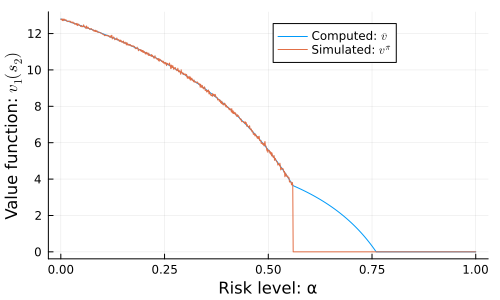

In [5]:
episodes :: Int = 100000
results :: DataFrame = DataFrame()
S0 = 2

# simulate the policy
for (riskindex, risk) ∈ enumerate(sol.Alpha)
    sims = simulateHdP(MDP, sol.π, sol.TransRisk , augment_state(S0,riskindex), T, episodes)
    cumrets = cumulative(sims, MDP.γ,T)
    riskcmp = sol.V̂[1][S0,riskindex]
    risksim = CVaR(distribution(cumrets,1/episodes),[sol.Alpha[riskindex]])[1]
    push!(results, (Risk = risk, computed=riskcmp, simulated = risksim))
end
    
plot(results.Risk, results.computed, label= L"Computed: $\bar{v}$", size = (500,300),
xlabel="Risk level: α",
ylabel= L"Value function: $v_1(s_2)$" ,
legend=(0.6,0.9))
plot!(results.Risk, results.simulated, label=L"Simulated: $v^{\bar{\pi}}$") |> display

After we read in a simple MDP, we will discretize our quantile into $101$ uniform levels, and only consider $T=2$.

To demonstrate the empirical plausible error of the algorithm, we will compute the true CVaR for all possible time dependent deterministic policy $\Pi_\forall$. Then we will compute the optimal value function with $\text{CVaR}_\alpha[ \mathfrak{R}^{\pi_\star}_{1:T}(s_0)] =  \max_{\pi \in \Pi_\forall} \{~\text{CVaR}_\alpha[\mathfrak{R}^\pi_{1:T}(s_0)] ~\}$ for all $\alpha , s_0 \in S$.

In [6]:
∀loc = [(i,j) for i in 1:T for j in MDP.S]
a2 = reduce(vcat,[collect(combinations(∀loc,i)) for i in 0:length(∀loc)])
function sparsePi(indexes,nRow,nCol)
    I = [i[1] for i in indexes]
    J = [i[2] for i in indexes]
    return(Array{Int8}(sparse(I,J,1,nRow,nCol)) .+ Int8(1)) 
end
Π∀ =[ sparsePi(act2,T,MDP.lSl) for act2 in a2]
nΠ∀ = length(Π∀)

16

Now we have all the combination of possible policies, we could compute their respective value function distribution, and then compute CVaR from each of the distribution and take the maximum as optimal policy.

In [7]:
function V_distribution(MDP,policy;T=10) # policy[t,s]
    V = [[DataFrame() for s in MDP.S] for t in 1:(T+1)]
    V[T+1] = [DataFrame(X = [0], p = [1]) for s in MDP.S]
    for t in T:-1:1
        for s in MDP.S
            a = policy[t,s]
            V[t][s] = RtγV(MDP.R[s,a,:],MDP.γ,V[t+1],MDP.P[s,a,:])
        end
    end
    return V
end

Vπ = unique([ V_distribution(MDP,policy;T=T) for policy in Π∀])
Alpha = LinRange(1,0,M)
t = 1
Real_optimal_CVaR = [ reduce((x,y) -> max.(x,y), [CVaR(v[t][s],Alpha) for v in Vπ]) for s in MDP.S]
s = 2
ErrMax = findmax(abs.(sol.V̂[t][s,:].-Real_optimal_CVaR[s]))
error = round(ErrMax[1],digits = 3)

2.667

Above calculated that the maximum deviation of True-CVaR vs Dynamically-CVaR in this simple problem is 2.4.

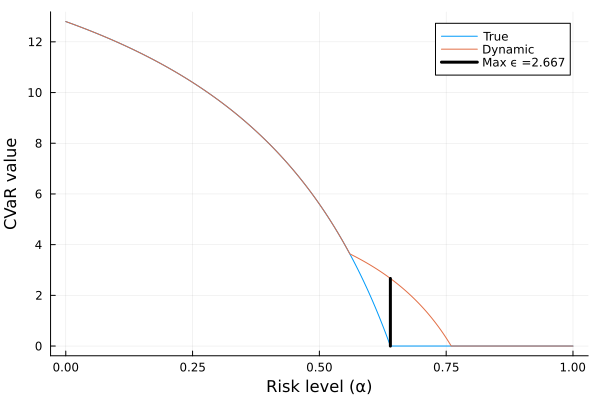

In [8]:
plot(Alpha, [Real_optimal_CVaR[s], sol.V̂[t][s,:]],label = ["True" "Dynamic"])
plot!([Alpha[ErrMax[2]],Alpha[ErrMax[2]]],[sol.V̂[t][s,ErrMax[2]],Real_optimal_CVaR[s][ErrMax[2]]], linewidth=3,lc=:black , label = raw"Max ϵ ="*"$error")
xlabel!("Risk level (α)")
ylabel!("CVaR value")

From this discounted two-states, two-actions, two-time simple example, the CVaR with quantile discretization yield an error of $2.4$ which is $8\%$ of the range of reward $30 = r_\text{max} - r_\text{min}$ at risk level $\alpha = 0.64$.

### Error arise conditions

The error arises when pseudocode step (2A) is called at time $t=1$ after the below conditions are met at time $t+1 = 2$:

For different states $s_1',s_2'$ with $\alpha_{1},\alpha_{2}$ respectively, if exists a state $s$ and action $a$ such that

1. For the (error donor) $s_1'$ at $\alpha_1$,
    
    a. the limit of risk for policy function at time $t+1$ from left is not the same as from right 
$$\lim_{\alpha_{L1} \to \alpha_{1}^-} \pi_{t+1}(s_1',\alpha_{L1}) = a_{L1} ~\neq~ a_{R1} = \lim_{\alpha_{R1} \to \alpha_{1}^+} \pi_{t+1}(s_1',\alpha_{R1}).$$

2. For the (error receiver) $s_2'$ at $\alpha_2$ with optimal action $\pi_{t+1}^\star{(s_2',\alpha_2)}$,

    a. there exist a quantile value $1-\alpha_2$ such that 
    $$\lim_{\alpha_{R1} \to \alpha_{1}^+} V_{t+1}[s_1',\alpha_{R1}] \leq \frac{R[s,a,s_2'] + \gamma V_{t+1}[s_2',\alpha_2] - R[s,a,s_1']}{\gamma}  < \lim_{\alpha_{L1} \to \alpha_{1}^-} V_{t+1}[s_1',\alpha_{L1}]$$
   

In [9]:
function AddPiecewisePlotCVaR(plt,d;linewidth = 1,label = "label",ls=:solid,lc=:blue)
    Psum = cumulativeSum(d.p)
    XTP = cumulativeSum(d.X .* d.p)
    plot!(plt,[0;Psum],[0;XTP],linewidth = linewidth ,label = label,ls=ls,lc=lc )
    return(plt)
end

function AddPiecewisePlotVaR(plt,d;linewidth = 1,label = "label",ls=:solid,lc=:blue)
    Psum = cumulativeSum(d.p)
    plot!(plt,[0;Psum],[d.X[1];d.X],linewidth = linewidth,label = label,ls=ls,lc=lc,linetype=:steppre)
    return(plt)
end

AddPiecewisePlotVaR (generic function with 1 method)

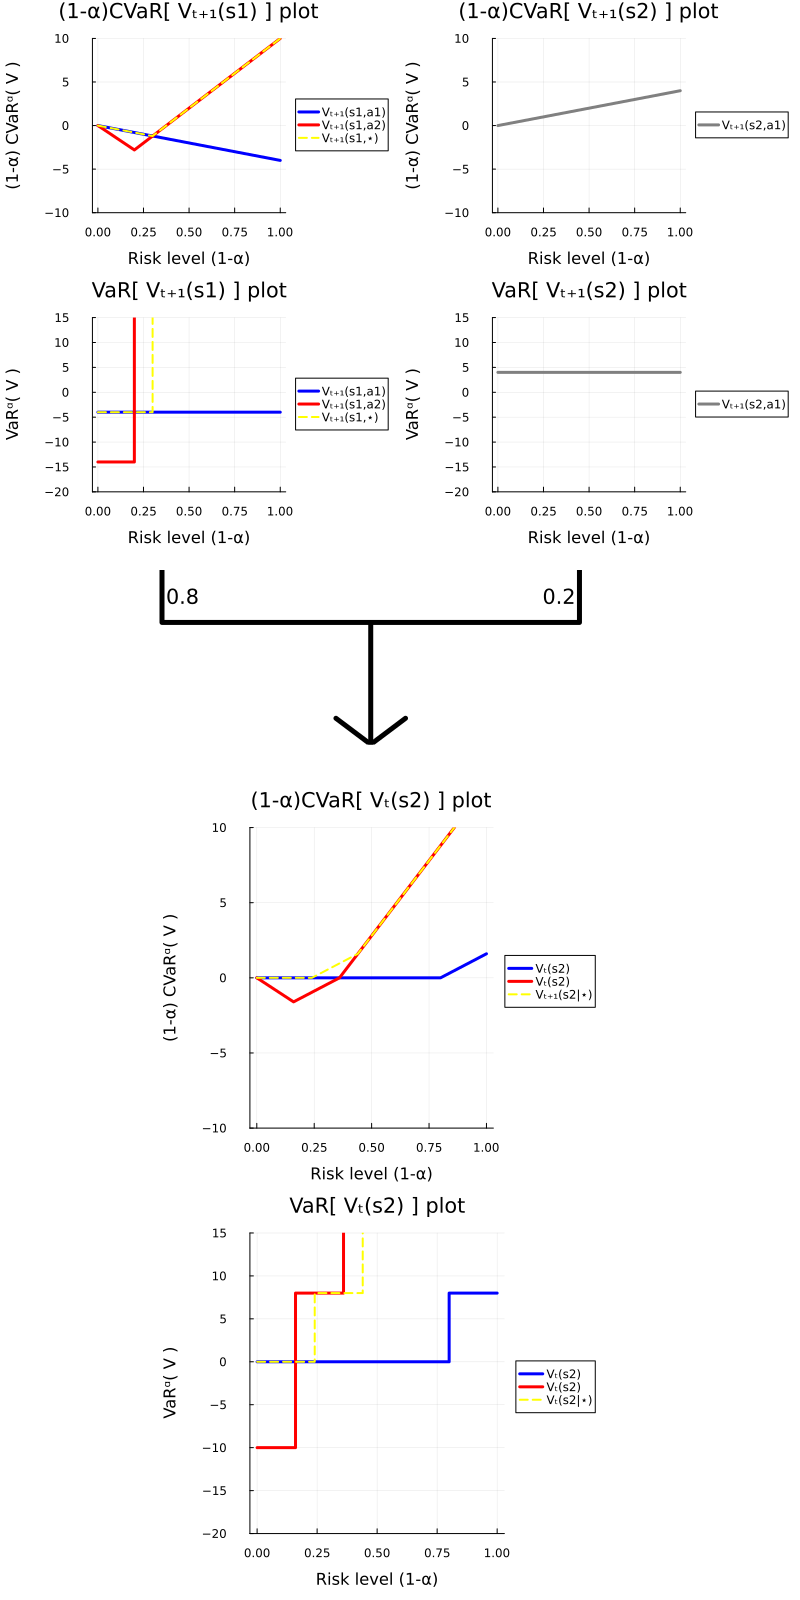

In [10]:
# Initialize variable with values so we know which variable we refering to
s1 = 1
s2 = 2
a1 = 1
a2 = 2
t1 = 1
t2 = 2
t1CVaRopts2 = CVaR2Distribution(Real_optimal_CVaR[s2],Alpha)
t2_CVaR = [ unique( [ v[t2][s] for v in Vπ] ) for s in MDP.S]
t2CVaRopt = [ CVaR2Distribution(reduce((x,y) -> max.(x,y),[ CVaR(D,Alpha) for D in t2_CVaR[s] ]),Alpha) for s in MDP.S]

# CVAR s=1 @ t+1
p1 = plot(
    legend=:outerright,title="(1-α)CVaR[ Vₜ₊₁(s1) ] plot",
    ylabel = "(1-α) CVaRᵅ( V )",xlabel = "Risk level (1-α)",ylim = (-10,10), left_margin=10Plots.mm
)
AddPiecewisePlotCVaR( p1,t2_CVaR[s1][a1];linewidth = 3,label = "Vₜ₊₁(s1,a1)")
AddPiecewisePlotCVaR( p1,t2_CVaR[s1][a2];linewidth = 3,label = "Vₜ₊₁(s1,a2)",lc=:red)
AddPiecewisePlotCVaR( p1,t2CVaRopt[s1];linewidth = 2,label = "Vₜ₊₁(s1,⋆)",ls=:dash,lc=:yellow)
# VAR s=1 @ t+1
p2 = plot(
    legend=:outerright,title="VaR[ Vₜ₊₁(s1) ] plot",
    ylabel = "VaRᵅ( V )",xlabel = "Risk level (1-α)",ylim = (-20,15), left_margin=10Plots.mm
)
AddPiecewisePlotVaR( p2,t2_CVaR[s1][a1];linewidth = 3,label = "Vₜ₊₁(s1,a1)")
AddPiecewisePlotVaR( p2,t2_CVaR[s1][a2];linewidth = 3,label = "Vₜ₊₁(s1,a2)" , lc=:red )
AddPiecewisePlotVaR( p2,t2CVaRopt[s1];linewidth = 2,label = "Vₜ₊₁(s1,⋆)",ls=:dash,lc=:yellow)

# CVAR s=2 @ t+1
p3 = plot(
    legend=:outerright,title="(1-α)CVaR[ Vₜ₊₁(s2) ] plot",
    ylabel = "(1-α) CVaRᵅ( V )",xlabel = "Risk level (1-α)",ylim = (-10,10), left_margin=10Plots.mm
)
AddPiecewisePlotCVaR( p3,t2_CVaR[s2][a1];linewidth = 3,label = "Vₜ₊₁(s2,a1)",lc=:grey)
# VAR s=2 @ t+1
p4 = plot(
    legend=:outerright,title="VaR[ Vₜ₊₁(s2) ] plot",
    ylabel = "VaRᵅ( V )",xlabel = "Risk level (1-α)",ylim = (-20,15), left_margin=10Plots.mm
)
AddPiecewisePlotVaR( p4,t2_CVaR[s2][a1];linewidth = 3,label = "Vₜ₊₁(s2,a1)",lc=:grey)

# Join distribution
pjoin = plot(
    [0.1,0.1,0.1,0.4,0.4,0.4,0.7,0.7,0.7],[1,0.85,0.7,0.7,0,0.7,0.7,0.85,1],lc=:black,
    bg = :white,xlim = (0, 1), ylim = (0, 1), linewidth = 5,
    framestyle = :none,legend = false,
    text=["", "      $(MDP.P[2,1,1])", "", "", "", "", "", "$(MDP.P[2,1,2])      ", ""]
)
plot!(pjoin,[0.35,0.4,0.45],[0.15,0,0.15], linewidth = 5,lc=:black)

# Plot up to t+1=2
pt2 = plot( plot(p1,p3,layout=(1,2)),plot(p2,p4,layout=(1,2)) ,pjoin,layout=(3,1))
    

# Look at CVaR for time t=1
t1s2_CVaR = unique( [ v[t1][s2] for v in Vπ] )
t1s2_optimistic = RtγV(MDP.R[s2,a1,:],MDP.γ,t2CVaRopt,MDP.P[s2,a1,:])
# CVAR s=2 @ t
p5 = plot(
    legend=:outerright,title="(1-α)CVaR[ Vₜ(s2) ] plot",
    ylabel = "(1-α) CVaRᵅ( V )",xlabel = "Risk level (1-α)",ylim = (-10,10), left_margin=50Plots.mm, right_margin=50Plots.mm
)
AddPiecewisePlotCVaR( p5,t1s2_CVaR[a1];linewidth = 3,label = "Vₜ(s2)")
AddPiecewisePlotCVaR( p5,t1s2_CVaR[a2];linewidth = 3,label = "Vₜ(s2)",lc=:red)
AddPiecewisePlotCVaR( p5,t1s2_optimistic;linewidth = 2,label = "Vₜ₊₁(s2|⋆)",ls=:dash,lc=:yellow)

# VAR s=2 @ t
p6 = plot(
    legend=:outerright,title="VaR[ Vₜ(s2) ] plot",
    ylabel = "VaRᵅ( V )",xlabel = "Risk level (1-α)",ylim = (-20,15), left_margin=50Plots.mm, right_margin=50Plots.mm
    
)
AddPiecewisePlotVaR( p6,t1s2_CVaR[a1];linewidth = 3,label = "Vₜ(s2)")
AddPiecewisePlotVaR( p6,t1s2_CVaR[a2];linewidth = 3,label = "Vₜ(s2)" , lc=:red )
AddPiecewisePlotVaR( p6,t1s2_optimistic;linewidth = 2,label = "Vₜ(s2|⋆)",ls=:dash,lc=:yellow)

pt1 = plot(p5,p6,layout=(2,1))

# Plot up to t+1=2
pt = plot(pt2,pt1 ,layout=(2,1),size = (800, 1600))

In our example, the CVaR after joint distribution of the previously optimal CVaR is no longer optimal. The Donor $a_L$ (s'1,a'1) expect to have a value of $12$ after $-18$ at $\alpha \in [0.2,0.3]$ but there exist a value of $0$ in the receiver (s'2) value distribution. When combining the conditional distributions of s'1 and s'2, the value results a shift to the right for the value $0$ from s'2 in the optimistic dynamic distribution, making the naive method an over approximation.

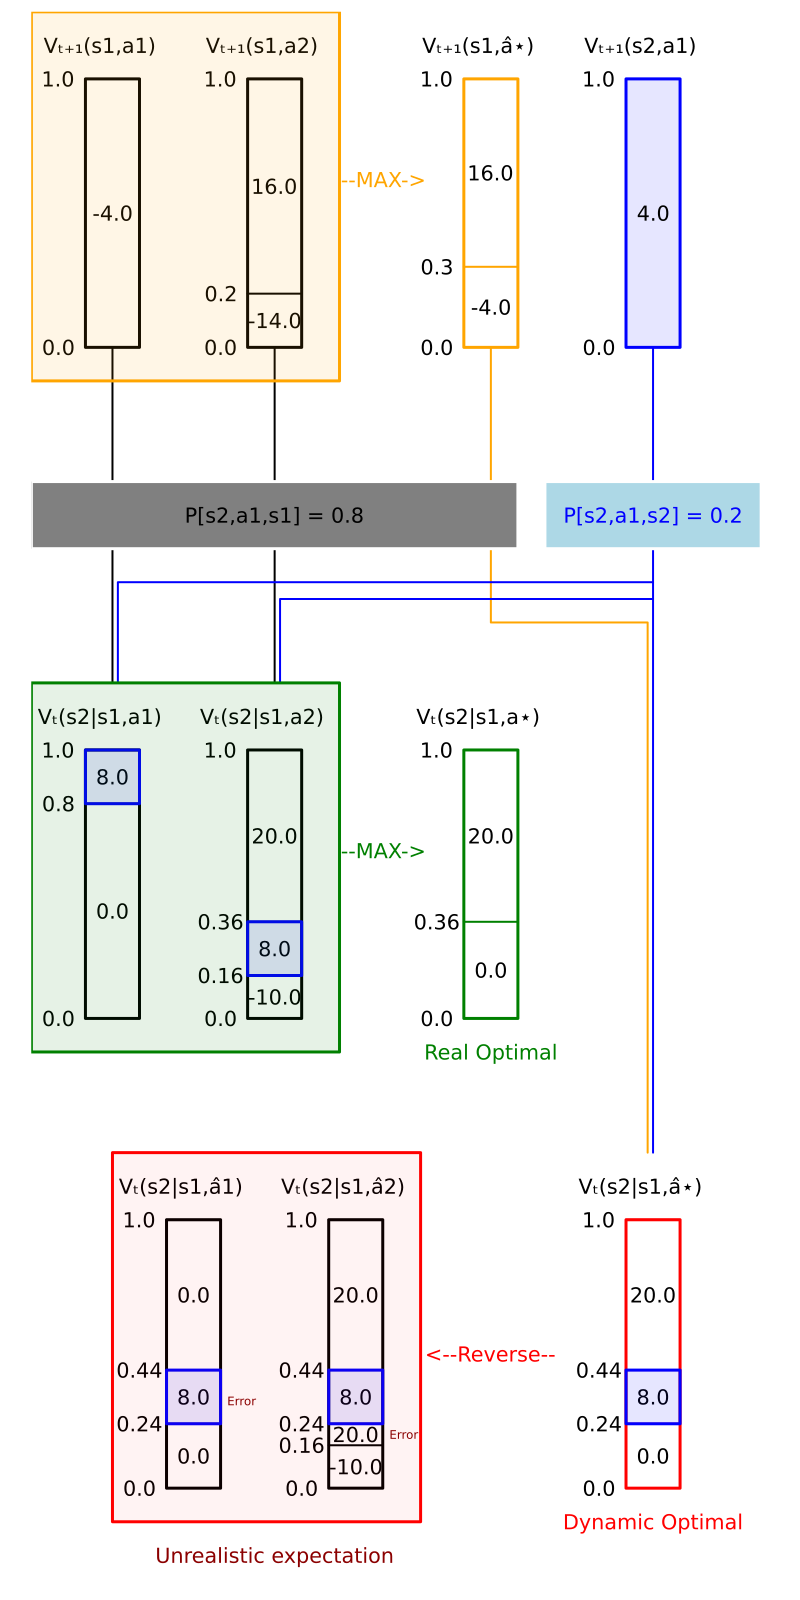

In [11]:
function BoxShape(plt,w,h;bw= 3,lc=:black,c = plot_color(:lightgreen, 0.1))
    plot!(plt,Shape([(w[2],h[2]),(w[2],h[1]),(w[1],h[1]),(w[1],h[2])]),linewidth = bw,lc=lc,c=c)
    return(plt)
end

function AddBox(plt,d;h = (0,0.8),w=(0,1),linewidth = 1,boxwidth= 3,title = "box",
    label = "label",ls=:solid,lc=:blue,lb=:black,fill=:white)
    Psum = [0;cumulativeSum(d.p)]
    # Plot empty box
    BoxShape(plt,w,h,bw=boxwidth,lc=lb,c=fill)
    # Plot title
    plot!(plt,[w[1]+0.025],[h[2]+0.1],text="$title")
    # write cdf[1] = 0  at the side
    plot!(plt,[w[1]-0.05],[h[1]],text="$(Psum[1])")
    for i in 2:length(Psum)
        # Plot cdf[i] line, value and text
        plot!(plt,[w[1];w[2]],h[1] .+ (h[2] - h[1]) .* [Psum[i];Psum[i]] ,linewidth=linewidth,ls=ls,lc=lc)
        plot!(plt,[(w[1] + (w[2]-w[1])/2)],[h[1]+(h[2] - h[1])*(Psum[i]+Psum[i-1])/2],text="$(round(d.X[i-1],sigdigits=3))")
        plot!(plt,[w[1]-0.05],[(h[1]+(h[2] - h[1])*Psum[i])],text="$(round(Psum[i],sigdigits=3))")
    end
    
    return(plt)
end

# Conditional distribution @ t+1
pbox = plot(
    bg = :white,xlim = (0, 1.4), ylim = (-3.6, 1), linewidth = 2,
    framestyle = :none,legend = false,size = (800, 1600)
)
AddBox(pbox,t2_CVaR[s1][a1],w=(0.1,0.2),linewidth = 2,title = "Vₜ₊₁(s1,a1)",lc=:black)
AddBox(pbox,t2_CVaR[s1][a2],w=(0.4,0.5),linewidth = 2,title = "Vₜ₊₁(s1,a2)",lc=:black)
AddBox(pbox,t2CVaRopt[s1],w=(0.8,0.9),linewidth = 2,title = "Vₜ₊₁(s1,â⋆)",lc=:orange,lb=:orange)
AddBox(pbox,t2_CVaR[s2][a1],w=(1.1,1.2),linewidth = 2,title = "Vₜ₊₁(s2,a1)",
lc=:blue,lb=:blue,fill = plot_color(:blue, 0.1))

# Line Vₜ₊₁(s1) to transitions
plot!(pbox,[0.15,0.15],[0,-1],linewidth = 2,lc=:black)
plot!(pbox,[0.45,0.45],[0,-1],linewidth = 2,lc=:black)
plot!(pbox,[0.85,0.85,1.14,1.14],[0,-0.82,-0.82,-2.4],linewidth = 2,lc=:orange)
# Line Vₜ₊₁(s2) to transitions
plot!(pbox,[1.15,1.15],[0,-2.4],linewidth = 2,lc=:blue)
plot!(pbox,[1.15,0.16,0.16],[-0.7,-0.7,-1],linewidth = 2,lc=:blue)
plot!(pbox,[1.15,0.46,0.46],[-0.75,-0.75,-1],linewidth = 2,lc=:blue)

# Add Transition Probability
BoxShape(pbox,(0,0.9),(-0.4,-0.6),lc=:white,c=:grey)
annotate!(pbox,[ (0.45,-0.5,("P[s2,a1,s1] = $(MDP.P[s2,a1,s1])",:black)) ] )

BoxShape(pbox,(0.95,1.35),(-0.4,-0.6),lc=:white,c =:lightblue)
annotate!(pbox,[ (1.15,-0.5,("P[s2,a1,s2] = $(MDP.P[s2,a1,s2])",:blue)) ] )

# Value function distribution at time t
AddBox(pbox,t1s2_CVaR[a1],w=(0.1,0.2),h=(-2,-1.2),linewidth = 2,title = "Vₜ(s2|s1,a1)",lc=:black)
AddBox(pbox,t1s2_CVaR[a2],w=(0.4,0.5),h=(-2,-1.2),linewidth = 2,title = "Vₜ(s2|s1,a2)",lc=:black)
AddBox(pbox,t1s2_optimistic,w=(1.1,1.2),h=(-3.4,-2.6),linewidth = 2,title = "Vₜ(s2|s1,â⋆)",lc=:red,lb=:red)
# Real optimal distribution 
AddBox(pbox,t1CVaRopts2,w=(0.8,0.9),h=(-2,-1.2),linewidth = 2,title = "Vₜ(s2|s1,a⋆)",lc=:green,lb=:green)

# Highlight value from s'=s2
BoxShape(pbox,(0.1,0.2),(-1.36,-1.2),lc=:blue,c = plot_color(:blue, 0.1))
BoxShape(pbox,(0.4,0.5),(-1.712,-1.872),lc=:blue,c = plot_color(:blue, 0.1))
BoxShape(pbox,(1.1,1.2),(-3.048,-3.208),lc=:blue,c = plot_color(:blue, 0.1))

# Value function distribution implied by the optimistic CVar

impliedD1 = DataFrame(X = t1s2_CVaR[a1].X[[1,2,1]], p = [0.24,0.2,0.56])
impliedD2 = DataFrame(X = t1s2_CVaR[a2].X[[1,3,2,3]], p = [0.16,0.08,0.2,0.56])
AddBox(pbox,impliedD1,w=(0.25,0.35),h=(-3.4,-2.6),linewidth = 2,title = "Vₜ(s2|s1,â1)",lc=:black)
AddBox(pbox,impliedD2,w=(0.55,0.65),h=(-3.4,-2.6),linewidth = 2,title = "Vₜ(s2|s1,â2)",lc=:black)

BoxShape(pbox,(0.25,0.35),(-3.048,-3.208),lc=:blue,c = plot_color(:blue, 0.1))
BoxShape(pbox,(0.55,0.65),(-3.048,-3.208),lc=:blue,c = plot_color(:blue, 0.1))

# Add text Max
annotate!(pbox,[ (0.65,0.5,("--MAX->",:orange)) ] )
BoxShape(pbox,(0,0.57),(1,-0.1),lc=:orange,c = plot_color(:orange, 0.1))

annotate!(pbox,[ (0.65,-1.5,("--MAX->",:green)) ] )
BoxShape(pbox,(0,0.57),(-1,-2.1),lc=:green,c = plot_color(:green, 0.1))
    
annotate!(pbox,[ (0.85,-3.0,("<--Reverse--",:red)) ] )
BoxShape(pbox,(0.15,0.72),(-2.4,-3.5),lc=:red,c = plot_color(:red, 0.05))

# Real vs Dynamic
annotate!(pbox,[ (0.85,-2.1,("Real Optimal",:green)) ] )
annotate!(pbox,[ (1.15,-3.5,("Dynamic Optimal",:red)) ] )
annotate!(pbox,[ (0.45,-3.6,("Unrealistic expectation",:darkred)) ] )

# Error Arise
annotate!(pbox,[ (0.69,-3.24,("Error",8,:red4)) ] )
annotate!(pbox,[ (0.39,-3.14,("Error",8,:red4)) ] )
# plot(pt,pbox ,layout=(1,2),size = (1600, 1600))

In [12]:
# Fast VaR function takes in a distribution (d) and a vector of risk (Alpha)
function VaR(d,Alpha)
    # Set lambda 
    Lambda = 1 .- Alpha
    
    M = length(Alpha)
    N = nrow(d)
    output = zeros(M)
    j = 1
    
    # Here we precompute repeatedly used values, Psum and XTP.
    d.Psum = cumsum(d.p)    
    for i in 1:N
        while (j <= M) && (Lambda[j] <= d.Psum[i])
            output[j] = d.X[i]
            j+=1
        end
    end  
    output[j:M] .= d.X[N]
    
    return output
end       

function derivedDistribution(d,Alpha,Values)
    # Set lambda 
    Lambda = 1 .- Alpha
    A = Int.(VaR(d,Alpha))
    return([Values[a][i] for (i,a) in enumerate(A)])
end


derivedDistribution (generic function with 1 method)

There are two possible actual outcomes to the dynamic optimal deterministic policy, depend on which action are selected as optimal policy at risk level of $\alpha = 1 - 0.3$, time $t+1$ for state $s1$ because the state action value function was a tie. Regardless which action is chosen as the optimal policy it suffer from certain regret to the real optimal policy for levels within $\alpha \in (0.24,0.44)$ at time $t$.

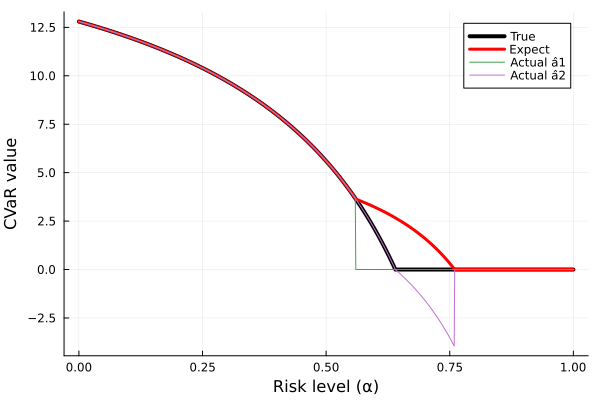

In [13]:
Values = unique([CVaR(v[1][2],Alpha) for v in Vπ])
PolicyD1 = DataFrame(X = [1,2], p = [0.44,0.56])
PolicyD2 = DataFrame(X = [1,2], p = [0.24,0.76])
cvarD1 = derivedDistribution(PolicyD1,Alpha,Values)
cvarD2 = derivedDistribution(PolicyD2,Alpha,Values)

plot(Alpha, Real_optimal_CVaR[s],label = "True" ,lw = 4 , lc =:black)
plot!(Alpha,sol.V̂[t][s,:],label = "Expect", lw = 3,lc =:red)
plot!(Alpha,cvarD1,label="Actual â1")
plot!(Alpha,cvarD2,label="Actual â2")
xlabel!("Risk level (α)")
ylabel!("CVaR value")